In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import time

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold , cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
import xgboost as xgb


In [ ]:
!unzip "/content/csc462-connect-4.zip" -d "/content/"

Archive:  /content/csc462-connect-4.zip
replace /content/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
testdata = pd.read_csv("/content/test.csv")
traindata = pd.read_csv("/content/train.csv")
valdata = pd.read_csv("/content/val.csv")

In [ ]:
def create_features(df_original):
    df = df_original.copy()

    feat_cols = [f"p{i}" for i in range(1, 43)]
    X = df[feat_cols].to_numpy()

    boards = X.reshape(-1, 6, 7)

    heights = (boards != 0).sum(axis=1)
    full = (heights == 6)

    df["center_open"] = (heights[:, 3] < 6)
    for j in range(7):
        df[f"h{j+1}"] = heights[:, j]
        df[f"full_c{j+1}"] = full[:, j]
    return df

BOARD = [f"p{i}" for i in range(1, 43)]

def normalize(df):
    out = df.copy()
    B = out[BOARD].to_numpy(dtype="int8")
    t = out["turn"].to_numpy(dtype="int8")    # ±1
    out[BOARD] = (B * t[:, None]).astype("int8")
    out["turn"] = 1
    return out



window of four

In [ ]:


ROWS, COLS = 6, 7
ME, OP, EMPTY = 1, -1, 0

def windows_of_four():
    # horizontal
    for r in range(ROWS):
        for c in range(COLS-3):
            yield [(r, c+i) for i in range(4)]
    # vertical
    for r in range(ROWS-3):
        for c in range(COLS):
            yield [(r+i, c) for i in range(4)]
    # diag down-right (↘)
    for r in range(ROWS-3):
        for c in range(COLS-3):
            yield [(r+i, c+i) for i in range(4)]
    # diag up-right (↗)
    for r in range(3, ROWS):
        for c in range(COLS-3):
            yield [(r-i, c+i) for i in range(4)]

W4 = list(windows_of_four())

def window_counts(board, me=ME, op=OP):
    w3_open = w2_open = opp_w3_open = opp_w2_open = 0
    for w in W4:
        vals = [board[r, c] for (r, c) in w]
        m = vals.count(me)
        o = vals.count(op)
        z = vals.count(EMPTY)
        if o == 0:  # only me + empties
            if m == 3 and z == 1: w3_open += 1
            elif m == 2 and z == 2: w2_open += 1
        if m == 0:  # only opp + empties
            if o == 3 and z == 1: opp_w3_open += 1
            elif o == 2 and z == 2: opp_w2_open += 1
    return dict(w3_open=w3_open, w2_open=w2_open,
                opp_w3_open=opp_w3_open, opp_w2_open=opp_w2_open)


BOARD_COLS = [f"p{i}" for i in range(1, 43)]  # p1..p42

def compute_window_features_for_row(row):
    # 1) take p1..p42 as flat array
    flat = row[BOARD_COLS].to_numpy(dtype="int8")  # shape: (42,)

    # 2) reshape to 6x7 board
    board = flat.reshape(6, 7)  # shape: (6, 7)

    # 3) call your function
    return window_counts(board)  # returns dict with 4 numbers


1-Lookahead

In [ ]:
ROWS, COLS = 6, 7
ME, OP, EMPTY = 1, -1, 0

def drop_piece(board, col, player):
    """
    Simulate dropping a piece for `player` in column `col`.
    Returns (new_board, row_index) or (None, None) if column is full.
    """
    if board[0, col] != EMPTY:
        return None, None  # column full

    new_board = board.copy()
    for r in range(ROWS-1, -1, -1):  # start from bottom
        if new_board[r, col] == EMPTY:
            new_board[r, col] = player
            return new_board, r

    return None, None  # should not reach here

def is_win(board, player):
    for w in W4:
        if all(board[r, c] == player for (r, c) in w):
            return True
    return False

def one_lookahead_features_for_row(row):
    # 1) build board (current player = +1)
    flat = row[BOARD_COLS].to_numpy(dtype="int8")
    board = flat.reshape(ROWS, COLS)

    feats = {}

    for c in range(COLS):
        col_name = c + 1  # to name features c1..c7

        # default values
        imm_win = 0
        landing_row = -1

        # try my move in this column
        new_board, r = drop_piece(board, c, ME)
        if new_board is None:
            # column full -> keep defaults
            feats[f"c{col_name}_immediate_win"] = imm_win
            feats[f"c{col_name}_row_after_drop"] = landing_row
            continue

        landing_row = r

        # (1) check if this move wins immediately (1-ply)
        if is_win(new_board, ME):
            imm_win = 1

        feats[f"c{col_name}_immediate_win"] = imm_win
        feats[f"c{col_name}_row_after_drop"] = landing_row

    # return as Series so pandas makes separate columns
    return pd.Series(feats)


In [ ]:
def add_all_features(df):
    # global window features
    window_feats = df.apply(compute_window_features_for_row, axis=1)

    # 1-lookahead column features
    lookahead_feats = df.apply(one_lookahead_features_for_row, axis=1)

    # reset_index to be safe, then concat horizontally
    df_out = pd.concat(
        [df.reset_index(drop=True),
         window_feats.reset_index(drop=True),
         lookahead_feats.reset_index(drop=True)],
        axis=1
    )
    return df_out


In [ ]:
#Data Split x, y
#--------------Encoding ---------------
train_featured = normalize(create_features(traindata))

valid_featured = normalize(create_features(valdata))
test_featured = normalize(create_features(testdata))

train_fe = add_all_features(train_featured)
val_fe   = add_all_features(valid_featured)
test_fe  = add_all_features(test_featured)


for col in train_fe.select_dtypes('bool').columns:
    train_fe[col] = train_fe[col].astype(int)

for col in val_fe.select_dtypes('bool').columns:
    val_fe[col] = val_fe[col].astype(int)

for col in test_fe.select_dtypes('bool').columns:
    test_fe[col] = test_fe[col].astype(int)

X_train = train_fe.drop('label_move_col', axis=1)
y_train = train_fe['label_move_col']

X_valid = val_fe.drop('label_move_col', axis=1)
y_valid = val_fe['label_move_col']

if "id" in test_fe.columns:
    X_test = test_fe.drop("id", axis=1)
else:
    X_test = test_fe
print(X_train.head())


#------------non encocded split-------------
train_x = traindata.drop(columns=['label_move_col'])
train_y = traindata['label_move_col']
val_x = valdata.drop(columns=['label_move_col'])
val_y = valdata['label_move_col']
test_x = testdata.drop(columns=['id'])


   p1  p2  p3  p4  p5  p6  p7  p8  p9  p10  ...  c3_immediate_win  \
0   0   1  -1   1  -1   0   1   0   1   -1  ...                 0   
1   0   1   1  -1   0   0   0   0  -1    0  ...                 0   
2   0  -1   1  -1   0   0  -1   0   0    1  ...                 0   
3  -1   0   0   0   1  -1  -1   1   0    0  ...                 0   
4  -1  -1   1   1   1  -1   1  -1   0    0  ...                 0   

   c3_row_after_drop  c4_immediate_win  c4_row_after_drop  c5_immediate_win  \
0                 -1                 0                 -1                 0   
1                 -1                 0                 -1                 0   
2                 -1                 0                 -1                 0   
3                  5                 0                  5                 0   
4                 -1                 0                 -1                 0   

   c5_row_after_drop  c6_immediate_win  c6_row_after_drop  c7_immediate_win  \
0                 -1           

In [ ]:
print("Train object cols:\n", train_fe.dtypes[train_fe.dtypes == "object"])
print("Valid object cols:\n", val_fe.dtypes[val_fe.dtypes == "object"])
print("Test object cols:\n", test_fe.dtypes[test_fe.dtypes == "object"])

Train object cols:
 0    object
dtype: object
Valid object cols:
 0    object
dtype: object
Test object cols:
 0    object
dtype: object


In [ ]:
import pandas as pd

def expand_dict_col_0(df):
    # df[0] is a Series of dicts -> expand to columns
    expanded = df[0].apply(pd.Series)
    # optional: you can rename or keep as is
    # expanded.columns will be ['w3_open','w2_open','opp_w3_open','opp_w2_open'] if that's what's in the dict

    # drop old column 0 and add expanded numeric columns
    df = pd.concat([df.drop(columns=[0]), expanded], axis=1)
    return df
train_fe = expand_dict_col_0(train_fe)
val_fe   = expand_dict_col_0(val_fe)
test_fe  = expand_dict_col_0(test_fe)


In [ ]:
print("Train object cols:\n", train_fe.dtypes[train_fe.dtypes == "object"])


Train object cols:
 Series([], dtype: object)


In [ ]:
import numpy as np

label_col = "label_move_col"
extra_drop = ["id"] if "id" in train_fe.columns else []

feature_cols = [c for c in train_fe.columns if c not in [label_col] + extra_drop]

X_train = train_fe[feature_cols].astype(np.float32).to_numpy()
X_valid = val_fe[feature_cols].astype(np.float32).to_numpy()
X_test  = test_fe[feature_cols].astype(np.float32).to_numpy()


y_train = traindata["label_move_col"].astype(int).to_numpy()
y_valid = valdata["label_move_col"].astype(int).to_numpy()

print("y_train unique:", np.unique(y_train))
print("y_valid unique:", np.unique(y_valid))


y_train unique: [0 1 2 3 4 5 6]
y_valid unique: [0 1 2 3 4 5 6]


In [ ]:



dtr = xgb.DMatrix(X_train, label=y_train)
dva = xgb.DMatrix(X_valid, label=y_valid)

# ---- 3) Parameters (multiclass) --------------------------------------------
num_class = 7
params = {
    "objective": "multi:softprob",   # probabilities over 7 classes
    "num_class": num_class,
    "eval_metric": "merror",         # multiclass error
    "eta": 0.05,                     # learning_rate
    "max_depth": 7,
    "min_child_weight": 2,
    "subsample": 0.85,
    "colsample_bytree": 0.85,
    "reg_lambda": 2.0,
    "tree_method": "hist",
    # Optional: if you have a strong first-player bias, a neutral prior helps
    "base_score": 1.0/num_class,     # safe prior for softmax
}

# ---- 4) Early stopping via CV (version-proof) -------------------------------
cv = xgb.cv(
    params=params,
    dtrain=dtr,
    num_boost_round=3000,
    nfold=5,
    early_stopping_rounds=80,
    seed=42,
    stratified=True,
    verbose_eval=False,
)

best_rounds = len(cv)
print("Best rounds:", best_rounds)

# ---- 5) Train final booster -------------------------------------------------
bst = xgb.train(
    params=params,
    dtrain=dtr,
    num_boost_round=best_rounds
)

# ---- 6) Validate ------------------------------------------------------------
probs = bst.predict(dva)             # shape: (n_valid, 7)
preds = probs.argmax(axis=1)
acc = accuracy_score(y_valid, preds)
print("Validation accuracy:", acc)



Best rounds: 876
Validation accuracy: 0.665769444960089


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# y_valid: ground-truth labels for the validation set (same encoding as preds)
labels = list(range(7))               # or: labels = le.classes_.tolist()
cm = confusion_matrix(y_valid, preds, labels=labels)
print(cm)

# Optional: normalized by true class (recall per row)
cm_norm = confusion_matrix(y_valid, preds, labels=labels, normalize='true')
print(cm_norm.round(3))

# Helpful summary metrics
print(classification_report(y_valid, preds, labels=labels, digits=3))


[[ 705   47   59  261   67   46  265]
 [  44  525   35  169   43   42   67]
 [  56   34  622  160   50   40   71]
 [ 114   64   69 3460   77   64  110]
 [  71   50   49  163  623   28   49]
 [  71   41   40  171   35  522   45]
 [ 262   46   63  258   59   46  716]]
[[0.486 0.032 0.041 0.18  0.046 0.032 0.183]
 [0.048 0.568 0.038 0.183 0.046 0.045 0.072]
 [0.054 0.033 0.602 0.155 0.048 0.039 0.069]
 [0.029 0.016 0.017 0.874 0.019 0.016 0.028]
 [0.069 0.048 0.047 0.158 0.603 0.027 0.047]
 [0.077 0.044 0.043 0.185 0.038 0.564 0.049]
 [0.181 0.032 0.043 0.178 0.041 0.032 0.494]]
              precision    recall  f1-score   support

           0      0.533     0.486     0.508      1450
           1      0.651     0.568     0.606       925
           2      0.664     0.602     0.631      1033
           3      0.745     0.874     0.805      3958
           4      0.653     0.603     0.627      1033
           5      0.662     0.564     0.609       925
           6      0.541     0.494     

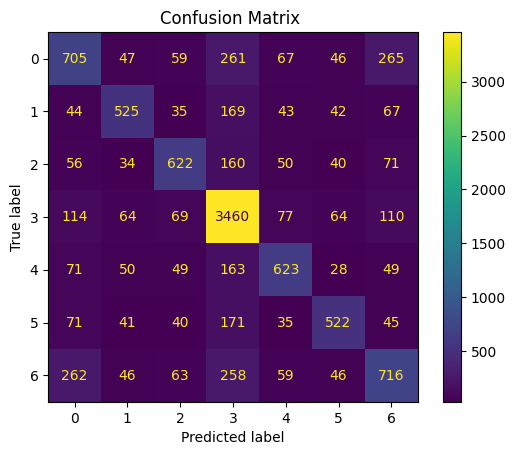

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(values_format='d')          # or values_format='.2f' for normalized cm
plt.title("Confusion Matrix ")
plt.show()



In [ ]:

dte = xgb.DMatrix(X_test)
probsX = bst.predict(dte)             # shape: (n_valid, 7)
predsX = probsX.argmax(axis=1)

In [ ]:
submit = pd.DataFrame({'id':testdata['id'],'label_move_col':predsX})

submit.to_csv('SubmissionXG.csv',index=False)